# Make a simple FeedForward network for the bus data

## Initialization

In [1]:
import sys
sys.path.append('../misc')

from MoviaBusDataset import MoviaBusDataset
from BaseNetwork import BaseNetwork
import torch
from torch.nn import Linear, Sequential, ReLU, L1Loss, BatchNorm1d
from torch.optim import Adam, lr_scheduler
import numpy as np

%load_ext autoreload
%autoreload 2


## Import data using the MoviaBusDataset

In [2]:
previous_timesteps = 6
prediction_steps = 6
batch_size = 25


train = MoviaBusDataset('../data/train', interpolation=True, 
                        prev_timesteps=previous_timesteps, 
                        max_future_time_steps=prediction_steps, 
                        timeofday = True,
                        agg_time=10)
test = MoviaBusDataset('../data/test', interpolation=True, 
                       prev_timesteps=previous_timesteps, 
                       max_future_time_steps=prediction_steps, 
                       timeofday = True,
                        agg_time=10)

#train.remove_trend()
#test.remove_trend(train._historical_average)

In [3]:
train.remove_trend()
test.remove_trend(train._historical_average)

## The Model

In [4]:
class FNN(BaseNetwork):
    def __init__(self, num_hidden):
        super().__init__()
        

        self.FNN = Sequential(
            Linear(previous_timesteps+1, num_hidden),
            ReLU(),
            #BatchNorm1d(193),
            Linear(num_hidden, num_hidden),
            ReLU(),
            #BatchNorm1d(193),
            Linear(num_hidden, 1),
        )

    def forward(self,x):
        """
        x : [batch_size, prev_timesteps, num_roads]
        
        """
        #Transpose input, such that the previous time steps are the last dimension
        x = x.transpose(2,1)

        predictions = []
        for _ in range(self.max_timestep):
            #Run the input through the network
            prediction = self.FNN(x).squeeze()

            #Append the prediction to the list of predictions. 
            #If the data includes timeofday, this shouldn't be included
            predictions.append(prediction[:,:self.num_roads])

            #remove oldest timestep
            x = x[:,:,1:]
            #unsqueeze output so its size is [batch_size, num_roads, timesteps]
            prediction = prediction.unsqueeze(2)

            #append the new prediction to the input
            x = torch.cat((x,prediction),dim=2)


        return torch.stack(predictions,1)

net = FNN(num_hidden=20)

optimizer_fun = lambda param : Adam(param, lr=1e-2, weight_decay=0)
scheduler_fun = lambda optim : lr_scheduler.StepLR(optim, step_size=10, gamma=0.1)
criterion = L1Loss()

## Training the network

In [ ]:
net.train_network(train, test,batch_size=batch_size, 
                  num_epochs=50,
                  optimizer_fun=optimizer_fun,
                  #scheduler_fun=scheduler_fun,
                  criterion=criterion)

epoch =  0  train loss = 1.318   test loss = 1.363   output_std = 1.091
epoch =  2  train loss = 1.221   test loss = 1.323   output_std = 1.166
epoch =  4  train loss = 1.207   test loss = 1.309   output_std = 1.091
epoch =  6  train loss = 1.200   test loss = 1.306   output_std = 1.209
epoch =  8  train loss = 1.193   test loss = 1.300   output_std = 1.211
epoch = 10  train loss = 1.189   test loss = 1.292   output_std = 1.158
epoch = 12  train loss = 1.188   test loss = 1.293   output_std = 1.195
epoch = 14  train loss = 1.185   test loss = 1.287   output_std = 1.155
epoch = 16  train loss = 1.189   test loss = 1.286   output_std = 1.169
epoch = 18  train loss = 1.186   test loss = 1.290   output_std = 1.162
epoch = 20  train loss = 1.184   test loss = 1.284   output_std = 1.112
epoch = 22  train loss = 1.178   test loss = 1.285   output_std = 1.230
epoch = 24  train loss = 1.177   test loss = 1.280   output_std = 1.151


## Evaluate the network on a test dataset 

In [19]:
scores=[net.get_MAE_score(timestep=i) for i in range(1,prediction_steps+1)]
print(scores)
print(sum(scores)/len(scores))

[0.31069570779800415, 1.5075876712799072, 1.529157280921936, 1.5388046503067017, 1.5495046377182007, 1.5614045858383179]
1.3328590889771779


### Example of modelled data vs real data for one road segment 

<IPython.core.display.Javascript object>


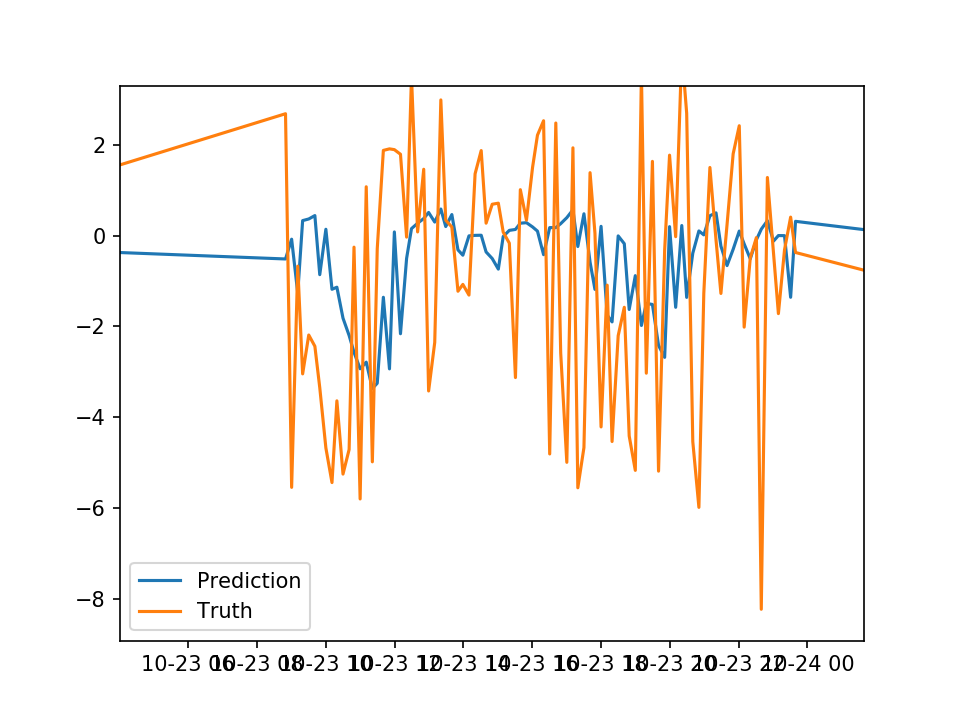

In [28]:
%matplotlib notebook

net.visualize_road(timesteps=6, road=17)

* prev=1
* lr=1e-4, weight_decay=0
* hidden=100
* MAE = 
[1.3296314477920532,1.5687475204467773,1.633176565170288, 1.6559220552444458,1.6670159101486206,1.6737109422683716]
1.5880340735117595



* prev=2
* lr=1e-4, weight_decay=0
* hidden=100
* MAE = 
[1.3325395584106445,1.5618607997894287,1.618654489517212,1.6406718492507935,1.6521214246749878, 1.659730076789856]
1.577596366405487



* prev=4
* lr=1e-4, weight_decay=0
* hidden=100
* MAE = 
[1.3421387672424316, 1.5452213287353516, 1.5943026542663574, 1.6157820224761963, 1.6295769214630127, 1.6383533477783203]
1.560895840326945



* prev=6
* lr=1e-4, weight_decay=0
* hidden=100
* MAE = 
[1.3075246810913086, 1.5262647867202759, 1.5778799057006836, 1.5982773303985596, 1.6123411655426025, 1.6229829788208008]
1.5408784747123718

* prev=8
* lr=1e-4, weight_decay=0
* hidden=100
* MAE = 
[1.3343786001205444, 1.5327132940292358, 1.5762120485305786, 1.595715045928955, 1.6098235845565796, 1.6211355924606323]
1.5449963609377544


* prev=12
* lr=1e-4, weight_decay=0
* hidden=100
* MAE = 
[1.3349711894989014, 1.5302950143814087, 1.571548581123352, 1.5893137454986572, 1.6023231744766235, 1.612109899520874]
1.5400936007499695
